In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
pip install umap-learn
import umap
pip install hdbscan
import hdbscan
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("feature_selection.csv")

# Dimensionality Reduction : PCA 

In [4]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()
# Fit data and get the variance ratio of each principal component
pca.fit(df)
# Retain 95% variance
pca = PCA(n_components=0.95)  # Automatically select the number of components
data_reduced = pca.fit_transform(df)
# Convert the reduced data into a DataFrame
pca_data = pd.DataFrame(data_reduced)

# 1. K-means

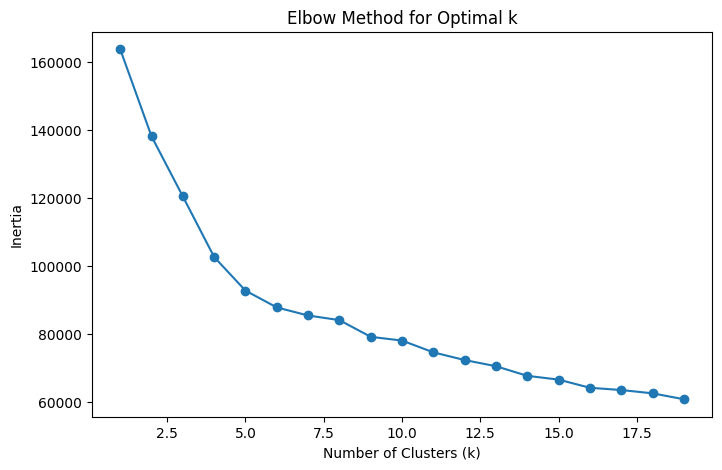

In [ ]:
# Test different numbers of clusters
distortions = []
K_range = range(1, 20)  # Test 1 to 20 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)  # Use the data after dimensionality reduction
    distortions.append(kmeans.inertia_)  # Sum of squared errors within clusters

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# Use silhouette score and visualization to further confirm the value of k
for k in range(5, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    silhouette = silhouette_score(pca_data, labels)
    print(f"k = {k}, Silhouette Score = {silhouette:.4f}")


k = 5, Silhouette Score = 0.2343
k = 6, Silhouette Score = 0.2299
k = 7, Silhouette Score = 0.2183
k = 8, Silhouette Score = 0.2044
k = 9, Silhouette Score = 0.2220
k = 10, Silhouette Score = 0.2015


# 2. Mini-Batch K-Means

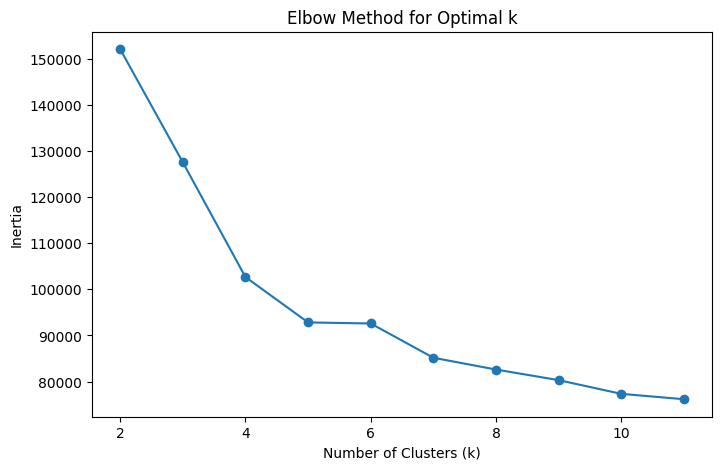

In [ ]:
distortions = []
K_range = range(2, 12)

for k in K_range:
    minikmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    minikmeans.fit(pca_data)
    distortions.append(minikmeans.inertia_)

# Plot the elbow method curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:

# Test different numbers of clusters
silhouette_scores = []
K_range = range(4, 7)

for k in K_range:
    minikmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    labels = minikmeans.fit_predict(pca_data)
    score = silhouette_score(pca_data, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Score = {score:.4f}")


k = 4, Silhouette Score = 0.2009
k = 5, Silhouette Score = 0.2343
k = 6, Silhouette Score = 0.2075


# 3. DBSCAN

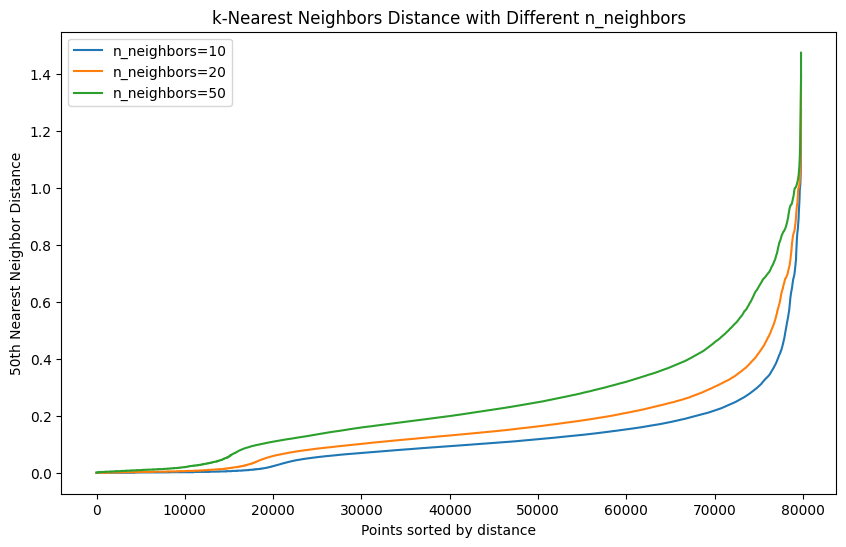

In [ ]:
# Determine parameter range
# Generate different k-nearest neighbor distance plots
# Define different n_neighbors values
n_neighbors_list = [10, 20, 50]

plt.figure(figsize=(10, 6))
for n_neighbors in n_neighbors_list:
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors_fit = neighbors.fit(pca_data)
    distances, indices = neighbors_fit.kneighbors(pca_data)

    # Take the distance of the nth nearest neighbor for each point
    distances = np.sort(distances[:, -1])
    plt.plot(distances, label=f'n_neighbors={n_neighbors}')

plt.title("k-Nearest Neighbors Distance with Different n_neighbors")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{n_neighbors}th Nearest Neighbor Distance")
plt.legend()
plt.show()


n_neighbors=10 (Blue curve):

The curve is relatively steep, indicating a smaller neighborhood range and stricter density determination.
The elbow point is approximately at ϵ≈0.2-0.3.

Suitable for detecting more small clusters, but may result in more noise points due to the smaller neighborhood range, especially for dispersed data.

n_neighbors=20 (Orange curve):

The curve becomes slightly smoother, indicating a larger neighborhood range and less strict density determination compared to the blue curve.

More suitable for dividing clusters with a relatively even data distribution.
The elbow point is approximately at ϵ≈0.3-0.5.

Suitable for detecting medium-sized clusters. Results in more even cluster division, reducing some noise points, but may slightly sacrifice the precision of smaller clusters.

n_neighbors=50 (Green curve):

The curve becomes smoother, indicating a significantly larger neighborhood range and a more lenient density determination.

More inclined to detect large dense clusters. The elbow point is approximately at ϵ≈0.5-0.8.

Fewer but larger clusters, which helps reduce noise points, but may merge some relatively sparse small clusters into larger ones.
Suitable for identifying sparse clusters or reducing the number of clusters.


In [ ]:
# Define parameter range
n_neighbors_list = [10, 20, 50]  # Corresponding to blue, orange, and green curves
eps_values = [0.2, 0.3, 0.5, 0.8]  # Based on the elbow points of different curves in the KNN distance plot

# Save results
results = []

# Iterate over combinations of n_neighbors and eps
for n_neighbors in n_neighbors_list:
    for eps in eps_values:
        # Set min_samples to n_neighbors
        min_samples = n_neighbors

        # Create and run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(pca_data)

        # Filter out cases with only one cluster or all points being noise
        if len(set(labels)) <= 1 or all(label == -1 for label in labels):
            silhouette = -1  # Unable to calculate silhouette score
            n_clusters = 0
        else:
            # Calculate silhouette score
            silhouette = silhouette_score(pca_data, labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise points

        # Save results
        results.append({
            'n_neighbors': n_neighbors,
            'eps': eps,
            'n_clusters': n_clusters,
            'silhouette_score': silhouette
        })

# Save results as DataFrame
df_results = pd.DataFrame(results)

# Display results
print(df_results)

# Sort by silhouette score
sorted_results = df_results.sort_values(by='silhouette_score', ascending=False)
print("\nBest parameter combination:")
print(sorted_results.head())

    n_neighbors  eps  n_clusters  silhouette_score
0            10  0.2         274          0.233624
1            10  0.3         191          0.291147
2            10  0.5         173          0.306248
3            10  0.8         118          0.327038
4            20  0.2         188          0.205480
5            20  0.3         153          0.286948
6            20  0.5         139          0.319975
7            20  0.8         106          0.329809
8            50  0.2         106          0.098032
9            50  0.3         104          0.246834
10           50  0.5         107          0.323670
11           50  0.8          91          0.326317

最佳参数组合：
    n_neighbors  eps  n_clusters  silhouette_score
7            20  0.8         106          0.329809
3            10  0.8         118          0.327038
11           50  0.8          91          0.326317
10           50  0.5         107          0.323670
6            20  0.5         139          0.319975


# 4. GMM

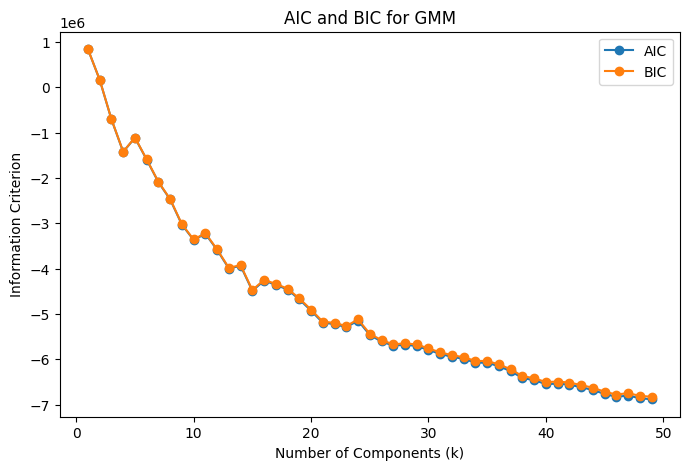

In [ ]:
# Use AIC and BIC to determine the optimal number of clusters
aic = []
bic = []
K_range = range(1, 50)  # Test 1 to 50 clusters

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(pca_data)
    aic.append(gmm.aic(pca_data))
    bic.append(gmm.bic(pca_data))

# Plot AIC and BIC curves
plt.figure(figsize=(8, 5))
plt.plot(K_range, aic, label='AIC', marker='o')
plt.plot(K_range, bic, label='BIC', marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC and BIC for GMM')
plt.show()


AIC and BIC decrease rapidly before k=10, indicating that a small number of clusters is not sufficient to describe the data well. After approximately k=30, the decrease in the BIC curve gradually slows down, and both AIC and BIC almost stop changing, suggesting that the model has achieved a good balance between goodness of fit and complexity at this point.

In [ ]:
k_values = [20, 30]
for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(pca_data)
    silhouette = silhouette_score(pca_data, labels)
    print(f"n_components = {k}, Silhouette Score = {silhouette:.4f}")

n_components = 20, Silhouette Score = 0.1932
n_components = 30, Silhouette Score = 0.2364


In [ ]:
covariance_types = ['full', 'tied', 'diag', 'spherical']
for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=30, covariance_type=cov_type, random_state=42)
    labels = gmm.fit_predict(pca_data)
    silhouette = silhouette_score(pca_data, labels)
    print(f"Covariance Type = {cov_type}, Silhouette Score = {silhouette:.4f}")

Covariance Type = full, Silhouette Score = 0.2364
Covariance Type = tied, Silhouette Score = 0.2691
Covariance Type = diag, Silhouette Score = 0.1992
Covariance Type = spherical, Silhouette Score = 0.1936
